In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches

# Cấu hình hiển thị biểu đồ đẹp hơn
plt.rcParams['figure.figsize'] = (16, 10)
plt.style.use('seaborn-v0_8-whitegrid')

# Tắt các cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')


In [7]:
def load_data():
    print(">>> Đang tải dữ liệu...")
    try:
        # 1. Tải keywords triệu chứng từ file
        keywords = pd.read_csv('../processed/keywords.csv')
        symptoms = keywords['symptom_keyword'].dropna().unique().tolist()
        
        # 2. ĐỊNH NGHĨA TỪ KHÓA SỰ KIỆN (Bổ sung thủ công)
        # Các từ này liên quan đến các tai nạn công nghiệp hoặc giao thông thường gây ra thảm họa
        event_keywords = [
            'accident', 'crash', 'truck', 'fire', 'smoke', 'gas', 'explosion', 
            'bridge', 'chemical', 'spill', 'overturn', 'police', 'blocked'
        ]
        
        # 3. Tải Microblogs
        mb = pd.read_csv('../processed/microblogs_clean.csv')
        mb['timestamp'] = pd.to_datetime(mb['timestamp'])
        
        # Lọc dữ liệu nhóm 2.4 (12/5 - 15/5)
        mb = mb[(mb['timestamp'] >= '2011-05-12') & (mb['timestamp'] < '2011-05-16')]
        
        # 4. Tải Thời tiết
        weather = pd.read_csv('../processed/weather_clean.csv')
        weather['timestamp'] = pd.to_datetime(weather['timestamp'])
        
        print(f"Đã tải {len(mb)} dòng microblogs.")
        print(f"Đã tải {len(weather)} dòng dữ liệu thời tiết.")
        return mb, weather, symptoms, event_keywords
    except Exception as e:
        print(f"Lỗi tải dữ liệu: {e}")
        return None, None, None, None

# Gọi hàm
df_mb, df_weather, symptoms, event_keywords = load_data()


>>> Đang tải dữ liệu...
Đã tải 182422 dòng microblogs.
Đã tải 4 dòng dữ liệu thời tiết.


In [8]:
def generate_keywords_algorithm(df_mb):
    print("\n>>> [THUẬT TOÁN] Đang trích xuất từ khóa đặc trưng (TF-IDF)...")
    
    corpus = df_mb['text_clean'].dropna().tolist()
    if not corpus: return []

    tfidf = TfidfVectorizer(stop_words='english', max_features=50, min_df=0.0005, max_df=0.85)
    
    try:
        tfidf_matrix = tfidf.fit_transform(corpus)
        feature_names = tfidf.get_feature_names_out()
        
        dense = tfidf_matrix.todense()
        episode_score = dense.mean(axis=0)
        tfidf_ranking = np.array(episode_score).flatten().argsort()[::-1]
        
        print("Top 15 từ khóa gợi ý bởi thuật toán:")
        top_words = []
        for i in range(min(15, len(feature_names))):
            word = feature_names[tfidf_ranking[i]]
            print(f"- {word}")
            top_words.append(word)
        return top_words
    except Exception as e:
        print(f"Lỗi TF-IDF: {e}")
        return []

if df_mb is not None:
    suggested_keywords = generate_keywords_algorithm(df_mb)



>>> [THUẬT TOÁN] Đang trích xuất từ khóa đặc trưng (TF-IDF)...
Top 15 từ khóa gợi ý bởi thuật toán:
- just
- like
- love
- newtwitter
- good
- time
- day
- new
- today
- lol
- dontyoujusthateitwhen
- life
- going
- twitter
- know


In [9]:
def engineer_features(df_mb, symptoms, event_keywords):
    df_mb['hour_bucket'] = df_mb['timestamp'].dt.floor('H')
    
    symptom_set = set([s.lower() for s in symptoms])
    event_set = set([e.lower() for e in event_keywords])
    
    # Hàm đếm từ khóa tối ưu
    def check_keywords(text, keyword_set):
        if not isinstance(text, str): return 0
        words = set(text.lower().split())
        return len(words.intersection(keyword_set))
    
    # Đánh dấu tweet bệnh
    df_mb['symptom_count'] = df_mb['text_clean'].apply(lambda x: check_keywords(x, symptom_set))
    df_mb['is_sick'] = df_mb['symptom_count'] > 0
    
    # Đánh dấu tweet sự kiện
    df_mb['event_count'] = df_mb['text_clean'].apply(lambda x: check_keywords(x, event_set))
    df_mb['is_event'] = df_mb['event_count'] > 0
    
    # Gom nhóm dữ liệu theo giờ
    hourly_stats = df_mb.groupby('hour_bucket').agg(
        total_tweets=('ID', 'count'),
        sick_tweets=('is_sick', 'sum'),
        event_tweets=('is_event', 'sum'),  # Thêm thống kê sự kiện
        avg_lat=('lat', 'mean'),
        avg_lon=('lon', 'mean')
    ).reset_index()
    
    hourly_stats['sick_ratio'] = hourly_stats['sick_tweets'] / hourly_stats['total_tweets']
    
    print("Đã tạo bảng thống kê theo giờ với cả dữ liệu Bệnh và Sự kiện.")
    return df_mb, hourly_stats

if df_mb is not None:
    df_mb, hourly_stats = engineer_features(df_mb, symptoms, event_keywords)
    display(hourly_stats.head())


Đã tạo bảng thống kê theo giờ với cả dữ liệu Bệnh và Sự kiện.


,hour_bucket,total_tweets,sick_tweets,event_tweets,avg_lat,avg_lon,sick_ratio
0,2011-05-12 00:00:00,1620,132,50,42.228968,93.377130,0.081481
1,2011-05-12 01:00:00,2019,157,58,42.230922,93.376526,0.077761
2,2011-05-12 02:00:00,1650,143,55,42.230077,93.380074,0.086667
3,2011-05-12 03:00:00,2156,152,162,42.230431,93.374378,0.070501
4,2011-05-12 04:00:00,1654,135,114,42.228183,93.379020,0.081620


In [10]:
def perform_kmeans_clustering(hourly_stats):
    print("\n>>> [PHÂN TÍCH] Đang chạy K-Means Clustering...")
    
    features = hourly_stats[['sick_tweets', 'sick_ratio']].fillna(0)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    hourly_stats['cluster'] = kmeans.fit_predict(scaled_features)
    
    cluster_means = hourly_stats.groupby('cluster')['sick_tweets'].mean().sort_values()
    labels_map = {
        cluster_means.index[0]: 'Bình thường (Low)',
        cluster_means.index[1]: 'Cảnh báo (Medium)',
        cluster_means.index[2]: 'Bùng phát (High)'
    }
    hourly_stats['status'] = hourly_stats['cluster'].map(labels_map)
    
    print("Kết quả phân cụm trạng thái dịch bệnh:")
    print(hourly_stats['status'].value_counts())
    return hourly_stats

if df_mb is not None:
    hourly_stats = perform_kmeans_clustering(hourly_stats)



>>> [PHÂN TÍCH] Đang chạy K-Means Clustering...
Kết quả phân cụm trạng thái dịch bệnh:
status
Cảnh báo (Medium)    47
Bình thường (Low)    26
Bùng phát (High)     23
Name: count, dtype: int64


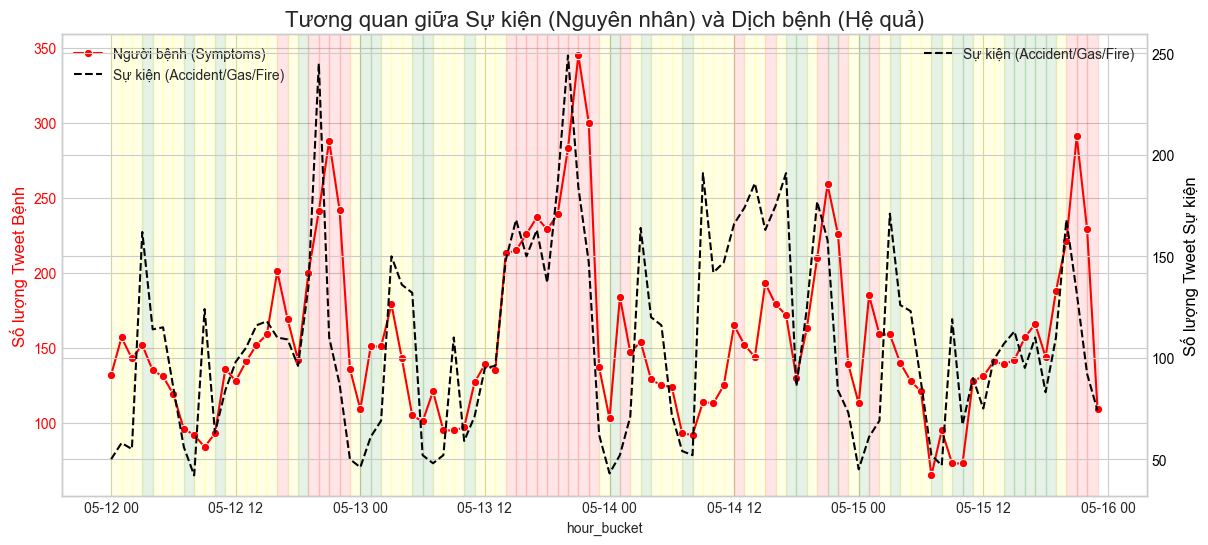

Thời điểm Sự kiện nghi ngờ: 2011-05-13 20:00:00
Thời điểm Dịch bùng phát: 2011-05-12 16:00:00


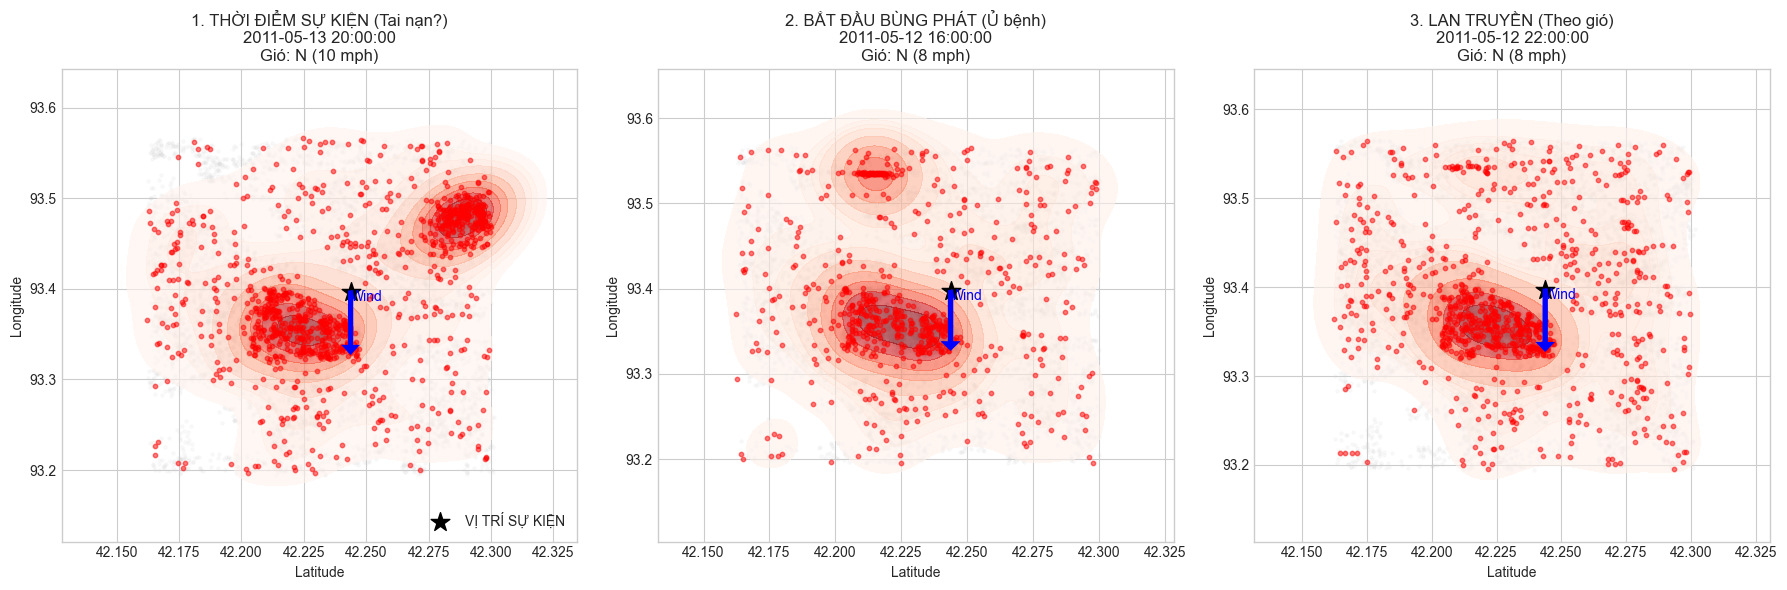

In [11]:
def plot_story_advanced(hourly_stats, df_mb, df_weather):
    # --- PHẦN 1: TƯƠNG QUAN THỜI GIAN (NGUYÊN NHÂN & HỆ QUẢ) ---
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Trục trái: Số ca bệnh
    sns.lineplot(data=hourly_stats, x='hour_bucket', y='sick_tweets', ax=ax1, color='red', marker='o', label='Người bệnh (Symptoms)')
    ax1.set_ylabel('Số lượng Tweet Bệnh', color='red', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='red')
    
    # Trục phải: Số sự kiện
    ax2 = ax1.twinx()
    sns.lineplot(data=hourly_stats, x='hour_bucket', y='event_tweets', ax=ax2, color='black', linestyle='--', label='Sự kiện (Accident/Gas/Fire)')
    ax2.set_ylabel('Số lượng Tweet Sự kiện', color='black', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='black')
    
    # Tô màu nền theo trạng thái dịch
    colors = {'Bình thường (Low)': 'green', 'Cảnh báo (Medium)': 'yellow', 'Bùng phát (High)': 'red'}
    for i in range(len(hourly_stats) - 1):
        status = hourly_stats.iloc[i]['status']
        start = hourly_stats.iloc[i]['hour_bucket']
        end = hourly_stats.iloc[i+1]['hour_bucket']
        ax1.axvspan(start, end, color=colors.get(status, 'white'), alpha=0.1)
        
    ax1.set_title("Tương quan giữa Sự kiện (Nguyên nhân) và Dịch bệnh (Hệ quả)", fontsize=16)
    
    # Gộp legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.show()
    
    # --- PHẦN 2: BẢN ĐỒ TRUY VẾT & HƯỚNG GIÓ ---
    try:
        # Tìm thời điểm sự kiện đạt đỉnh (Khả năng cao là lúc tai nạn xảy ra)
        peak_event_time = hourly_stats.loc[hourly_stats['event_tweets'].idxmax()]['hour_bucket']
        
        # Tìm thời điểm dịch bùng phát (chuyển sang High)
        outbreak_start = hourly_stats[hourly_stats['status'] == 'Bùng phát (High)']['hour_bucket'].min()
        
        print(f"Thời điểm Sự kiện nghi ngờ: {peak_event_time}")
        print(f"Thời điểm Dịch bùng phát: {outbreak_start}")
        
        # Chọn 3 mốc thời gian để vẽ bản đồ
        times = [peak_event_time, outbreak_start, outbreak_start + pd.Timedelta(hours=6)]
        titles = ["1. THỜI ĐIỂM SỰ KIỆN (Tai nạn?)", "2. BẮT ĐẦU BÙNG PHÁT (Ủ bệnh)", "3. LAN TRUYỀN (Theo gió)"]
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Tìm vị trí trung tâm của sự kiện (để vẽ ngôi sao)
        event_data = df_mb[(df_mb['timestamp'] >= peak_event_time) & 
                           (df_mb['timestamp'] < peak_event_time + pd.Timedelta(hours=2)) & 
                           (df_mb['is_event'] == True)]
        event_center = (event_data['lat'].mean(), event_data['lon'].mean()) if len(event_data) > 0 else None
        
        for i, t in enumerate(times):
            if pd.isna(t): continue
            ax = axes[i]
            
            # Lấy dữ liệu +/- 2 tiếng
            subset = df_mb[(df_mb['timestamp'] >= t - pd.Timedelta(hours=2)) & 
                           (df_mb['timestamp'] <= t + pd.Timedelta(hours=2))]
            sick_subset = subset[subset['is_sick'] == True]
            
            # Vẽ nền
            ax.scatter(subset['lat'], subset['lon'], c='lightgrey', s=5, alpha=0.1)
            
            # Vẽ Heatmap người bệnh
            if len(sick_subset) > 5:
                sns.kdeplot(data=sick_subset, x='lat', y='lon', fill=True, cmap='Reds', alpha=0.6, ax=ax, warn_singular=False)
                ax.scatter(sick_subset['lat'], sick_subset['lon'], c='red', s=10, alpha=0.5)
            
            # Đánh dấu vị trí sự kiện (Ngôi sao đen)
            if event_center:
                ax.scatter(event_center[0], event_center[1], c='black', s=200, marker='*', label='VỊ TRÍ SỰ KIỆN')
                if i == 0: ax.legend(loc='lower right')
            
            # Thông tin gió
            w_row = df_weather[df_weather['timestamp'].dt.date == t.date()].iloc[0]
            wind_info = f"Gió: {w_row['Wind_Direction']} ({w_row['Average_Wind_Speed']} mph)"
            
            ax.set_title(f"{titles[i]}\n{t}\n{wind_info}")
            ax.set_xlabel("Latitude")
            ax.set_ylabel("Longitude")
            
            # Vẽ mũi tên gió từ trung tâm sự kiện (nếu có)
            if event_center:
                wind_map = {'N': (0, -0.02), 'S': (0, 0.02), 'E': (-0.02, 0), 'W': (0.02, 0),
                           'NW': (0.015, -0.015), 'SW': (0.015, 0.015), 'NE': (-0.015, -0.015), 'SE': (-0.015, 0.015)}
                u, v = wind_map.get(w_row['Wind_Direction'], (0,0))
                if u!=0 or v!=0:
                    ax.arrow(event_center[0], event_center[1], u*3, v*3, head_width=0.005, color='blue', linewidth=2)
                    ax.text(event_center[0], event_center[1]-0.01, "Wind", color='blue')

        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Có lỗi khi vẽ bản đồ nâng cao: {e}")

if df_mb is not None:
    plot_story_advanced(hourly_stats, df_mb, df_weather)


In [13]:
extract_evidence()

--- ĐANG TRÍCH XUẤT BẰNG CHỨNG TỪ DỮ LIỆU MICROBLOGS ---

==================== 1. TAI NẠN (Nguyên nhân) ====================
Tìm thấy 3939 tweet liên quan.
--------------------------------------------------------------------------------
            ID           timestamp           Location  \
58825    58573 2011-05-13 00:01:00  42.16935 93.44469   
736        758 2011-05-13 00:02:00  42.27815 93.44269   
53143    53024 2011-05-13 00:04:00  42.22508 93.35762   
93322    92822 2011-05-13 00:04:00  42.21388 93.32886   
160982  159175 2011-05-13 00:05:00  42.20651 93.21463   
127716  126526 2011-05-13 00:07:00  42.23275 93.35562   
115390  114232 2011-05-13 00:08:00  42.20768 93.41154   
89341    88808 2011-05-13 00:09:00  42.28493 93.42033   
149841  148268 2011-05-13 00:09:00  42.18675 93.40675   
146774  145161 2011-05-13 00:10:00  42.25663 93.46626   
133303  132016 2011-05-13 00:11:00  42.23186 93.36002   
125997  124829 2011-05-13 00:13:00  42.21948 93.39357   
6963      6998 2011-05